In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.dates as mdates
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

In [68]:
df = pd.read_csv('FPT.csv', index_col ="Date/Time")
df.head()

,Ticker,Open,High,Low,Close,Volume,Open Interest
Date/Time,,,,,,,
12/25/2018 9:15,FPT,30.89,30.89,30.89,30.89,35410,0
12/25/2018 9:16,FPT,30.81,30.81,30.81,30.81,190,0
12/25/2018 9:17,FPT,30.74,30.81,30.74,30.74,1120,0
12/25/2018 9:18,FPT,30.74,30.74,30.74,30.74,2120,0
12/25/2018 9:19,FPT,30.74,30.74,30.74,30.74,22500,0


In [69]:
df = df.iloc[:, 4:5]
df = df.dropna()
df.index = pd.to_datetime(df.index)
df = df.resample('12H').mean().dropna()
df.head()

,Close
Date/Time,
2018-12-25 00:00:00,30.760000
2018-12-26 00:00:00,31.084878
2018-12-26 12:00:00,30.985455
2018-12-27 00:00:00,31.315696
2018-12-27 12:00:00,31.354364


In [70]:
scaler = MinMaxScaler(feature_range=(0,1))
df_Close_scaled = scaler.fit_transform(np.array(df.Close).reshape(-1,1))
df_Close_scaled.shape

(997, 1)

In [71]:
train_size = int(len(df_Close_scaled)*0.65)
test_size = len(df_Close_scaled) - train_size
train_data,test_data = df_Close_scaled[0:train_size,:],df_Close_scaled[train_size:len(df_Close_scaled),:1]

In [72]:
def create_dataset(dataset, time_step = 1):
    dataX,dataY = [],[]
    for i in range(len(dataset)-time_step-1):
                   a = dataset[i:(i+time_step),0]
                   dataX.append(a)
                   dataY.append(dataset[i + time_step,0])
    return np.array(dataX),np.array(dataY)

In [73]:
time_step = 100
X_train, y_train =  create_dataset(train_data,time_step)
X_test, y_test =  create_dataset(test_data,time_step)

In [74]:
print(X_train.shape)
print(X_train)
print(X_test.shape)
print(y_test.shape)

(547, 100)
[[0.0135276  0.02536871 0.02174494 ... 0.15521239 0.1532777  0.1469388 ]
 [0.02536871 0.02174494 0.03378154 ... 0.1532777  0.1469388  0.15208806]
 [0.02174494 0.03378154 0.03519089 ... 0.1469388  0.15208806 0.14311218]
 ...
 [0.50455487 0.52405803 0.51860923 ... 0.38100702 0.40065541 0.45387808]
 [0.52405803 0.51860923 0.52308931 ... 0.40065541 0.45387808 0.4503973 ]
 [0.51860923 0.52308931 0.54336896 ... 0.45387808 0.4503973  0.44335165]]
(248, 100)
(248,)


In [75]:
model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
model .add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model .add(Dropout(0.2))
model .add(LSTM(units = 50, return_sequences = True))
model .add(Dropout(0.2))
model .add(LSTM(units = 50, return_sequences = True))
model .add(Dropout(0.2))
model .add(LSTM(units = 50))
model .add(Dropout(0.2))

model .add(Dense(units = 1))

model .compile(optimizer = 'adam', loss = 'mean_squared_error')

In [76]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 100, 50)           10400     
                                                                 
 dropout_16 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_17 (LSTM)              (None, 100, 50)           20200     
                                                                 
 dropout_17 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_18 (LSTM)              (None, 100, 50)           20200     
                                                                 
 dropout_18 (Dropout)        (None, 100, 50)           0         
                                                                 
 lstm_19 (LSTM)              (None, 50)               

In [77]:
model.fit(X_train, y_train,epochs = 100, batch_size = 64,verbose = 1)

Epoch 1/100
9/9 [==============================] - 7s 29ms/step - loss: 0.1059
Epoch 2/100
9/9 [==============================] - 0s 21ms/step - loss: 0.0186
Epoch 3/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0135
Epoch 4/100
9/9 [==============================] - 0s 19ms/step - loss: 0.0099
Epoch 5/100
9/9 [==============================] - 0s 18ms/step - loss: 0.0084
Epoch 6/100
9/9 [==============================] - 0s 18ms/step - loss: 0.0077
Epoch 7/100
9/9 [==============================] - 0s 18ms/step - loss: 0.0063
Epoch 8/100
9/9 [==============================] - 0s 16ms/step - loss: 0.0064
Epoch 9/100
9/9 [==============================] - 0s 19ms/step - loss: 0.0066
Epoch 10/100
9/9 [==============================] - 0s 18ms/step - loss: 0.0064
Epoch 11/100
9/9 [==============================] - 0s 18ms/step - loss: 0.0065
Epoch 12/100
9/9 [==============================] - 0s 17ms/step - loss: 0.0060
Epoch 13/100
9/9 [==============================]

In [78]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

8/8 [==============================] - 0s 8ms/step


In [79]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [80]:
print(np.mean((y_train - train_predict)**2))
print(np.mean((y_test  - test_predict)**2))

1788.3528037965925
2339.3264387164872


In [81]:
look_back = 100

In [82]:
trainPredictPlot = np.empty_like(df_Close_scaled)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back : len(train_predict)+look_back,:] = train_predict

In [83]:
testPredictPlot = np.empty_like(df_Close_scaled)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict)+(look_back)*2 + 1 : len(df_Close_scaled) - 1,:] = test_predict

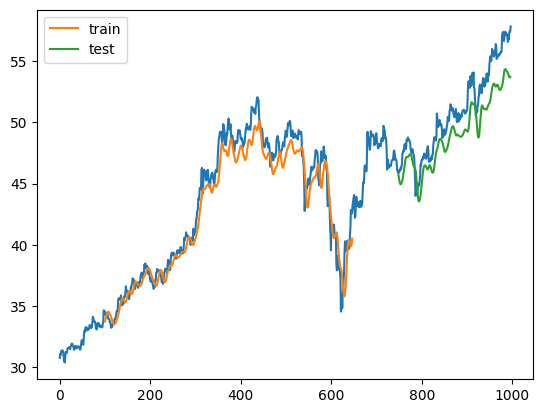

In [84]:
plt.plot(scaler.inverse_transform(df_Close_scaled))
plt.plot(trainPredictPlot, label = 'train')
plt.plot(testPredictPlot, label = 'test')
plt.legend()
plt.show()